<a href="https://colab.research.google.com/github/OSegun/Zummit-Africa-ML-AL-Projects/blob/main/Face_Recognition_with_CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from glob import glob
import os
from zipfile import ZipFile

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hereisburak/pins-face-recognition

 97% 359M/372M [00:02<00:00, 174MB/s]
100% 372M/372M [00:02<00:00, 156MB/s]


In [4]:
# Upload data and extract the contents

dataset = '/content/pins-face-recognition.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
base_dir = '/content/105_classes_pins_dataset'

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [6]:
import shutil

filenames = [i for i in os.listdir(base_dir)]
for filename in filenames[:46]:
  if filename.startswith('pins_'):
    src = os.path.join(base_dir, filename)
    dst = os.path.join(train_dir, filename)
    #print(src, dst)
    shutil.copytree(src, dst)

filenames = [i for i in os.listdir(base_dir)]
for filename in filenames[91:]:
  if filename.startswith('pins_'):
    src = os.path.join(base_dir, str(filename))
    dst = os.path.join(test_dir, str(filename))
    #print(src,dst)
    shutil.copytree(src, dst)


filenames = [i for i in os.listdir(base_dir)]
for filename in filenames[46:91]:
  if filename.startswith('pins_'):
    src = os.path.join(base_dir, filename)
    dst = os.path.join(val_dir, filename)
    #print(src,dst)
    shutil.copytree(src, dst)

IMAGE_SIZE = [224, 224]

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/105_classes_pins_dataset/train',
                                                 target_size = (224, 224),
                                                 color_mode = 'rgb',
                                                  shuffle = True,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7383 images belonging to 45 classes.


In [9]:
val_set = test_datagen.flow_from_directory('/content/105_classes_pins_dataset/val',
                                            target_size = (224, 224),
                                           color_mode = 'rgb',
                                           shuffle = True,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7799 images belonging to 45 classes.


In [10]:
#vgg = VGG16(include_top=False)
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [12]:
folders = glob('/content/train/*')

print(len(training_set))

231


In [16]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(45, activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
# tell the model what cost and optimization method to use
from tensorflow.keras.optimizers.legacy import Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [18]:
# fit the model
# Run the cell. It will take some time to execute
model_ch = model.fit(
  training_set,
  validation_data=val_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/50
231/231 [==============================] - 128s 547ms/step - loss: 2.8687 - accuracy: 0.3187 - val_loss: 8.2133 - val_accuracy: 0.0372
Epoch 2/50
231/231 [==============================] - 119s 517ms/step - loss: 1.4899 - accuracy: 0.5942 - val_loss: 8.7749 - val_accuracy: 0.0255
Epoch 3/50
231/231 [==============================] - 119s 517ms/step - loss: 1.0504 - accuracy: 0.7049 - val_loss: 9.4845 - val_accuracy: 0.0269
Epoch 4/50
231/231 [==============================] - 120s 521ms/step - loss: 0.8000 - accuracy: 0.7615 - val_loss: 10.2798 - val_accuracy: 0.0224
Epoch 5/50
231/231 [==============================] - 119s 516ms/step - loss: 0.6602 - accuracy: 0.8046 - val_loss: 10.5949 - val_accuracy: 0.0345
Epoch 6/50
231/231 [==============================] - 120s 521ms/step - loss: 0.5472 - accuracy: 0.8417 - val_loss: 11.5317 - val_accuracy: 0.0256
Epoch 7/50
231/231 [==============================] - 120s 519ms/step - loss: 0.4898 - accuracy: 0.8480 - val_loss: 11.99

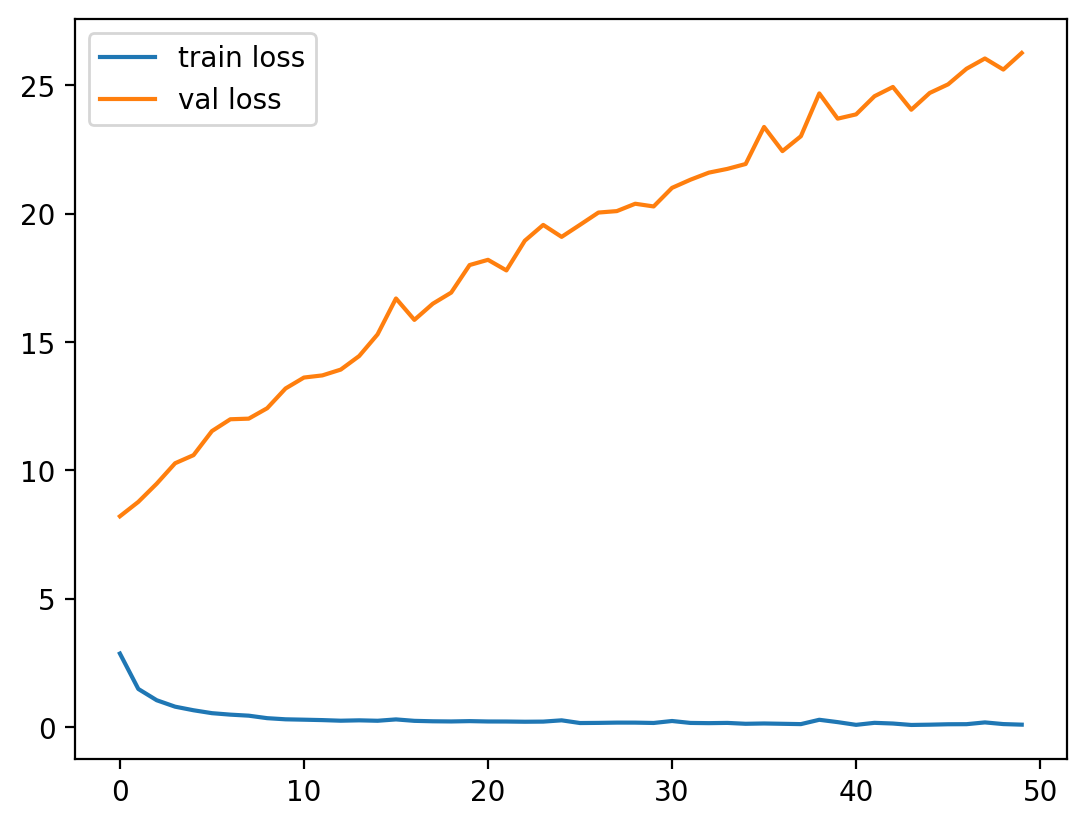

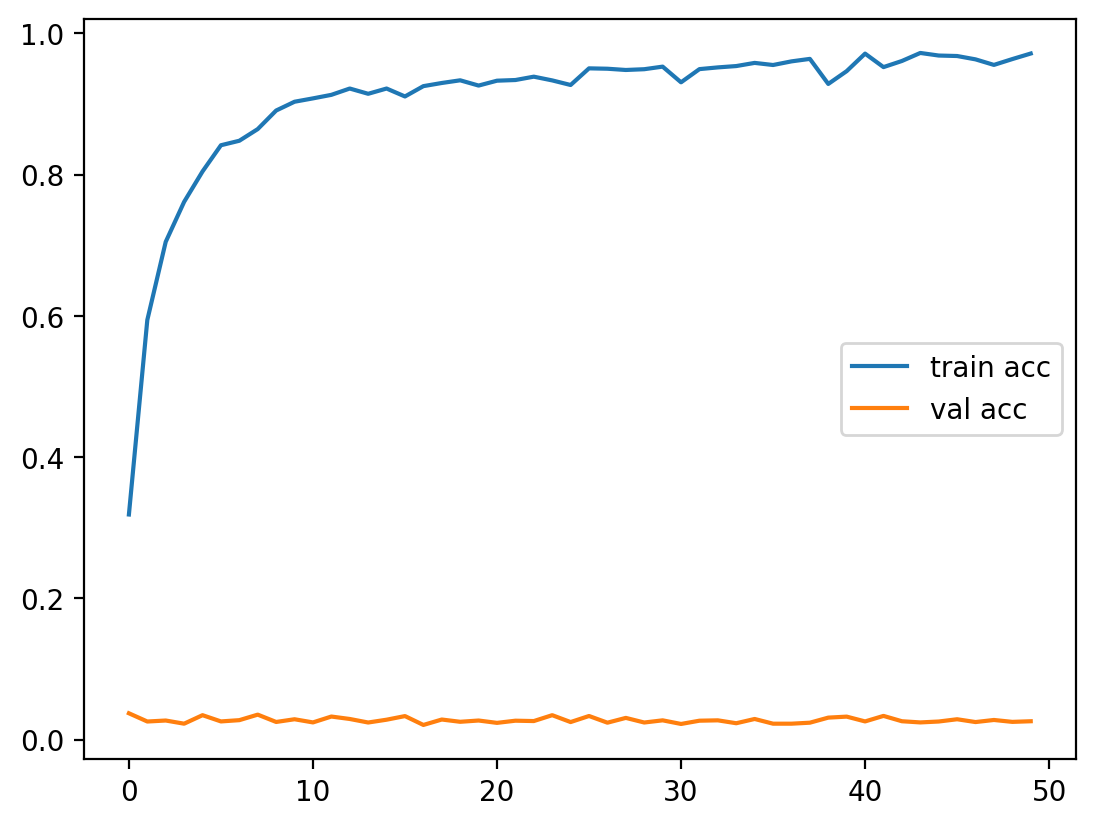

<Figure size 640x480 with 0 Axes>

In [19]:
# plot the loss
plt.plot(model_ch.history['loss'], label='train loss')
plt.plot(model_ch.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_ch.history['accuracy'], label='train acc')
plt.plot(model_ch.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_inception.h5')

y_pred = model_ch.predict(val_set)